<a href="https://colab.research.google.com/github/Paul-mwaura/ML-Hackathons/blob/main/The_Kvasir_Capsule_Image_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Content
 
The small bowel constitutes the gastrointestinal (GI) tract’s mid-part, situated between the stomach and the large bowel. It is three to four meters long and has a surface of about 30 m^2, including the surface of the villi, and plays a crucial role in absorbing nutrients. Therefore, disorders in the small bowel may cause severe growth retardation in children and nutrient deﬁciencies in children and adults. This organ may be affected by chronic diseases, like Crohn’s disease, coeliac disease, and angiectasis,or malignant diseases like lymphoma and adenocarcinoma. These diseases may represent a substantial health challenge for both patients and society, and a thorough examination of the lumen is frequently necessary to diagnose and treat them. However, the small bowel, due to its anatomical location, is less accessible for inspection by ﬂexible endoscopes commonly used for the upper GI tract and the large bowel. Since early 2000, video capsule endoscopy (VCE) has been used, usually as a complementary test for patients with GI bleeding. A VCE consists of a small capsule containing a wide-angle camera, lightsources, batteries, and other electronics. The patient swallows the capsule, which then captures a video as it moves passively through the GI tract. A recorder, carried by the patient or included in the capsule, stores the video before a medical expert assesses it after the procedure. [Source of information: Reasearch paper: Kvasir-Capsule, a video capsule endoscopy dataset]


 

## Problem Statement
Artificial intelligence (AI) is predicted to have profound effects on the future of video capsule endoscopy (VCE) technology.The potential lies in improving anomaly detection while reducing manual labour. However, medical data is often sparse and unavailable to the research community, and qualified medical personnel rarely have time for the tedious labelling work.

 



### Objective
You are required to build a machine learning model to recognize the disease label of the respective images.

In [1]:
!pip install nvidia-smi

In [2]:
!nvidia-smi

Mon Jun 28 05:11:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1yDcNMTI-8Zq2Mvs8qe7pLNpPx4BW5Yta',
dest_path='content/The Kvasir-Capsule.zip',
unzip=True)

### Loading Libraries

In [4]:
import pandas as pd # Data analysis and manipultion tool
import numpy as np # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf # Deep Learning Tool
import os # OS module in Python provides a way of using operating system dependent functionality
import cv2 # Library for image processing
from sklearn.model_selection import train_test_split # For splitting the data into train and validation set
from sklearn.metrics import f1_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Loading and preparing training data
The train and test images are given in two different folders - 'train' and 'test'. The labels of train images are given in a csv file 'Train.csv' with respective image id (i.e. image file name).

**Getting the labels of the images**

In [5]:
labels = pd.read_csv("/content/content/The Kvasir-Capsule/Training_set.csv") # loading the labels
labels.head() # will display the first five rows in labels dataframe

,filename,label
0,Image_1.jpg,Normal clean mucosa
1,Image_2.jpg,Normal clean mucosa
2,Image_3.jpg,Foreign body
3,Image_4.jpg,Normal clean mucosa
4,Image_5.jpg,Normal clean mucosa


In [6]:
labels.tail() # will display the last five rows in labels dataframe

,filename,label
37785,Image_37786.jpg,Normal clean mucosa
37786,Image_37787.jpg,Normal clean mucosa
37787,Image_37788.jpg,Normal clean mucosa
37788,Image_37789.jpg,Ileocecal valve
37789,Image_37790.jpg,Ileocecal valve


### Getting images file path

In [7]:
file_paths = [[fname, '/content/content/The Kvasir-Capsule/train/' + fname] for fname in labels['filename']]

### Confirming if no. of labels is equal to no. of images

In [8]:
# Confirm if number of images is same as number of labels given
if len(labels) == len(file_paths):
  print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
  print('Number of labels does not match the number of filenames')

Number of labels i.e.  37790 matches the number of filenames i.e.  37790


### Converting the file_paths to dataframe

In [9]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,/content/content/The Kvasir-Capsule/train/Imag...
1,Image_2.jpg,/content/content/The Kvasir-Capsule/train/Imag...
2,Image_3.jpg,/content/content/The Kvasir-Capsule/train/Imag...
3,Image_4.jpg,/content/content/The Kvasir-Capsule/train/Imag...
4,Image_5.jpg,/content/content/The Kvasir-Capsule/train/Imag...


### Combining the labels with the images

In [10]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,/content/content/The Kvasir-Capsule/train/Imag...,Normal clean mucosa
1,Image_2.jpg,/content/content/The Kvasir-Capsule/train/Imag...,Normal clean mucosa
2,Image_3.jpg,/content/content/The Kvasir-Capsule/train/Imag...,Foreign body
3,Image_4.jpg,/content/content/The Kvasir-Capsule/train/Imag...,Normal clean mucosa
4,Image_5.jpg,/content/content/The Kvasir-Capsule/train/Imag...,Normal clean mucosa


The 'train_data' dataframe contains all the image id, their locations and their respective labels. Now the training data is ready.

In [11]:
img3 = train_data['filepaths'].loc[2]

Populating the interactive namespace from numpy and matplotlib


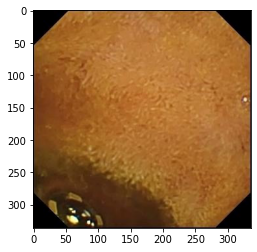

In [12]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img3)
imgplot = plt.imshow(img)
plt.show()

In [13]:
def f(r):
  if r == "ampulla_of_vater":
    return 0
  elif r == "Angiectasia":
    return 1
  elif r == "Blood - fresh":
    return 2
  elif r == "Blood - hematin":
    return 3
  elif r == "Erosion":
    return 4
  elif r == "Erythema":
    return 5
  elif r == "Foreign body":
    return 6
  elif r == "Ileocecal valve":
    return 7
  elif r == "Lymphangiectasia":
    return 8
  elif r == "Normal clean mucosa":
    return 9
  elif r == "Polyp":
    return 10
  elif r == "Pylorus":
    return 11
  elif r == "Reduced mucosal view":
    return 12
  else:
    return 13

train_data['label'] = train_data['label'].apply(f)

## Data Pre-processing
It is necessary to bring all the images in the same shape and size, also convert them to their pixel values because all machine learning or deep learning models accepts only the numerical data. Also we need to convert all the labels from categorical to numerical values.

In [ ]:
data = [] # initialize an empty numpy array
image_size = 200 # image size taken is 100 here. one can take other size too
for i in range(len(train_data)):

  img_array = cv2.imread(train_data['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale
  img_array = img_array/255.0
  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array
  data.append([new_img_array, train_data['label'][i]])

In [ ]:
batch_size = 40
img_height = 200
img_width = 200

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.Resizing(
        img_height, img_width, interpolation='bilinear'),
    
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
   
    layers.experimental.preprocessing.RandomRotation(0.1, seed=2, name=None),
    layers.experimental.preprocessing.RandomZoom(0.1, seed=2, name=None),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=2, name=None),
    layers.experimental.preprocessing.RandomContrast(0.1, seed=2, name=None),
  ]
)

In [ ]:
# image pixels of a image
data[0]

### Shuffle the data

In [ ]:
np.random.shuffle(data)

### Separating the images and labels

In [ ]:
x = []
y = []
for image in data:
  x.append(image[0])
  y.append(image[1])

# converting x & y to numpy array as they are list
x = np.array(x)
y = np.array(y)

In [ ]:
np.unique(y, return_counts=True)

Splitting the data into Train and Validation Set
We want to check the performance of the model that we built. For this purpose, we always split (both independent and dependent data) the given data into training set which will be used to train the model, and test set which will be used to check how accurately the model is predicting outcomes.

For this purpose we have a class called 'train_test_split' in the 'sklearn.model_selection' module.

In [ ]:
x = x.reshape(-1, 200, 200, 1)

In [ ]:
# split the data
X_train, X_val, y_train, y_val = train_test_split(x,y,test_size=0.2, random_state = 42)

### Building Model
Now we are finally ready, and we can train the model.

There are many machine learning or deep learning models like Random Forest, Decision Tree, Multi-Layer Perceptron (MLP), Convolution Neural Network (CNN), etc. to say you some.

Then we would feed the model both with the data (X_train) and the answers for that data (y_train)

In [ ]:
cnn = tf.keras.models.Sequential([
data_augmentation,

tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(200, 200, 1)),
tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
tf.keras.layers.MaxPooling2D((2, 2)),

# tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(14, activation='sigmoid')
])

In [ ]:
cnn.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

In [ ]:
cnn.fit(X_train, y_train, epochs=20, batch_size=40)

### Validate the model
Wonder🤔 how well your model learned! Lets check its performance on the X_val data.

In [ ]:
cnn.evaluate(X_val, y_val)

## Predict The Output For Testing Dataset 😅
We have trained our model, evaluated it and now finally we will predict the output/target for the testing data (i.e. Test.csv).



### Load Test Set
Load the test data on which final submission is to be made.

In [ ]:
# Loading the order of the image's name that has been provided
test_image_order = pd.read_csv("/content/content/The Kvasir-Capsule/Testing_set.csv")
test_image_order.head()

### Getting images file path

In [ ]:
file_paths = [[fname, '/content/content/The Kvasir-Capsule/test/' + fname] for fname in test_image_order['filename']]

### Converting the file_paths to dataframe

In [ ]:
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.head()

## Data Pre-processing on test_data

In [ ]:
test_pixel_data = [] # initialize an empty numpy array
image_size = 200 # image size taken is 150 here. one can take other size too
for i in range(len(test_images)):

  img_array = cv2.imread(test_images['filepaths'][i], cv2.IMREAD_GRAYSCALE) # converting the image to gray scale

  new_img_array = cv2.resize(img_array, (image_size, image_size)) # resizing the image array

  test_pixel_data.append(new_img_array)

In [ ]:
test_pixel_data = np.array(test_pixel_data)

In [ ]:
test_pixel_data = test_pixel_data.reshape(-1, 200, 200, 1)

### Make Prediction on Test Dataset

In [ ]:
pred = cnn.predict(test_pixel_data)

In [ ]:
# The predicted values are the probabilities value
pred[0]

The above values are probability values. We need to convert it into respective classes. We can use np.argmax for the same.

In [ ]:
prediction = []
for value in pred:
  prediction.append(np.argmax(value))

In [ ]:
predictions = []
for r in prediction:
  if r == 0:
    predictions.append("ampulla_of_vater")
  elif r == 1:
    predictions.append("Angiectasia")
  elif r == 2:
    predictions.append("Blood - fresh")
  elif r == 3:
    predictions.append("Blood - hematin")
  elif r == 4:
    predictions.append("Erosion")
  elif r == 5:
    predictions.append("Erythema")
  elif r == 6:
    predictions.append("Foreign body")
  elif r == 7:
    predictions.append("Ileocecal valve")
  elif r == 8:
    predictions.append("Lymphangiectasia")
  elif r == 9:
    predictions.append("Normal clean mucosa")
  elif r == 10:
    predictions.append("Polyp")
  elif r == 11:
    predictions.append("Pylorus")
  elif r == 12:
    predictions.append("Reduced mucosal view")
  else:
    predictions.append("ulcer")

### Save prediction results locally via colab notebook

In [ ]:
res = pd.DataFrame({'filename': test_images['filename'], 'label': predictions}) # prediction is nothing but the final predictions of your model on input features of your new unseen test data
res.to_csv("submission.csv", index = False)

# To download the csv file locally
from google.colab import files
files.download('submission.csv')